# **第9章: RNNとCNN**

**setup**

In [ ]:
#ファイルのダウンロード、解凍
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip ./NewsAggregatorDataset.zip

--2023-12-26 06:07:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [     <=>            ]  27.87M  28.1MB/s    in 1.0s    

2023-12-26 06:07:39 (28.1 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  ./NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


**80. ID番号への変換**

In [ ]:
# データのロード
import pandas as pd
import re
import numpy as np

# ファイル読み込み
file = './newsCorpora.csv'
data = pd.read_csv(file, encoding='utf-8', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
data = data.replace('"', "'")
# 特定のpublisherのみ抽出
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)

# 前処理
def preprocessing(text):
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    text_clean = re.sub('[0-9]+', '0', text_clean)
    text_clean = re.sub('\s-\s', ' ', text_clean)
    return text_clean

data['TITLE'] = data['TITLE'].apply(preprocessing)

# 学習用、検証用、評価用に分割する
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=64, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=64, stratify=valid_test['CATEGORY'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
検証データ
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
評価データ
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
# 単語の辞書を作成
from collections import Counter
words = []
for text in train['TITLE']:
    for word in text.rstrip().split():
        words.append(word)
c = Counter(words)
word2id = {}
for i, cnt in enumerate(c.most_common()):
    if cnt[1] > 1:
        word2id[cnt[0]] = i + 1
for i, cnt in enumerate(word2id.items()):
    if i >= 10:
        break
    print(cnt[0], cnt[1])

to 1
0 2
in 3
as 4
on 5
UPDATE 6
for 7
The 8
of 9
US 10


In [ ]:
# 単語のID化
def tokenizer(text):
    words = text.rstrip().split()
    return [word2id.get(word, 0) for word in words]

sample = train.at[0, 'TITLE']
print(sample)
print(tokenizer(sample))

Justin Bieber Under Investigation For Attempted Robbery At Dave  Busters
[68, 76, 782, 1974, 21, 5054, 5055, 34, 1602, 0]


**81. RNNによる予測**

In [ ]:
import torch
from torch import nn

VOCAB_SIZE = 4
EMB_SIZE = 3
emb = nn.Embedding(VOCAB_SIZE, EMB_SIZE)

words = torch.tensor([1, 3, 0, 2, 1, 2])
embed_words = emb(words)
print(embed_words)
print(words.shape, '->', embed_words.shape)

tensor([[-1.5417,  1.8061, -2.7073],
        [ 0.5717, -0.7518, -0.6477],
        [ 1.6629,  0.3748, -1.1300],
        [ 1.8850,  1.5584,  0.2615],
        [-1.5417,  1.8061, -2.7073],
        [ 1.8850,  1.5584,  0.2615]], grad_fn=<EmbeddingBackward0>)
torch.Size([6]) -> torch.Size([6, 3])


In [ ]:
!pip install torchinfo

In [ ]:
# RNNの作成
# モデルの構築
import random
import torch
from torch import nn
import torch.utils.data as data
from torchinfo import summary

# 乱数のシードを設定
# parserなどで指定
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        x = self.emb(x)
        x, h = self.rnn(x, h0)
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2  # 辞書のID数 + unknown + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
print(model)

RNN(
  (emb): Embedding(9725, 300, padding_idx=9724)
  (rnn): LSTM(300, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=4, bias=True)
)


In [ ]:
x = torch.tensor([tokenizer(sample)], dtype=torch.int64)
print(x)
print(x.size())
print(nn.Softmax(dim=-1)(model(x)))

tensor([[  68,   76,  782, 1974,   21, 5054, 5055,   34, 1602,    0]])
torch.Size([1, 10])
tensor([[0.2783, 0.2129, 0.2804, 0.2284]], grad_fn=<SoftmaxBackward0>)


**82. 確率的勾配降下法による学習**

In [ ]:
# ターゲットのテンソル化
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['CATEGORY'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['CATEGORY'].map(category_dict).values)
Y_test = torch.from_numpy(test['CATEGORY'].map(category_dict).values)
print(Y_train.size())
print(Y_train)

torch.Size([10672])
tensor([2, 0, 2,  ..., 0, 0, 0])


In [ ]:
class NewsDataset(data.Dataset):
    """
    newsのDatasetクラス

    Attributes
    ----------------------------
    X : データフレーム
        単語ベクトルの平均をまとめたテンソル
    y : テンソル
        カテゴリをラベル化したテンソル
    phase : 'train' or 'val'
        学習か訓練かを設定する
    """
    def __init__(self, X, y, phase='train'):
        self.X = X['TITLE']
        self.y = y
        self.phase = phase

    def __len__(self):
        """全データサイズを返す"""
        return len(self.y)

    def __getitem__(self, idx):
        """idxに対応するテンソル形式のデータとラベルを取得"""
        inputs = torch.tensor(tokenizer(self.X[idx]))
        return inputs, self.y[idx]

train_dataset = NewsDataset(train, Y_train, phase='train')
valid_dataset = NewsDataset(valid, Y_valid, phase='val')
test_dataset = NewsDataset(test, Y_test, phase='val')
# 動作確認
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])
print(valid_dataset.__getitem__(idx)[0].size())
print(valid_dataset.__getitem__(idx)[1])
print(test_dataset.__getitem__(idx)[0].size())
print(test_dataset.__getitem__(idx)[1])

torch.Size([10])
tensor(2)
torch.Size([11])
tensor(3)
torch.Size([13])
tensor(2)


In [ ]:
# DataLoaderを作成
batch_size = 1

train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)
print(inputs.size())
print(labels)

torch.Size([1, 11])
tensor([2])


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return train_loss, train_acc, valid_loss, valid_acc

# 学習を実行する

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 5
--------------------------------------------


100%|██████████| 10672/10672 [06:18<00:00, 28.21it/s]


train Loss: 0.9959, Acc: 0.6041


100%|██████████| 1334/1334 [00:01<00:00, 935.88it/s]


val Loss: 0.7686, Acc: 0.7391
Epoch 2 / 5
--------------------------------------------


100%|██████████| 10672/10672 [07:46<00:00, 22.89it/s]


train Loss: 0.6217, Acc: 0.7737


100%|██████████| 1334/1334 [00:01<00:00, 971.36it/s]


val Loss: 0.6238, Acc: 0.7729
Epoch 3 / 5
--------------------------------------------


100%|██████████| 10672/10672 [07:41<00:00, 23.13it/s]


train Loss: 0.3893, Acc: 0.8622


100%|██████████| 1334/1334 [00:01<00:00, 768.27it/s]


val Loss: 0.5844, Acc: 0.8013
Epoch 4 / 5
--------------------------------------------


100%|██████████| 10672/10672 [07:40<00:00, 23.16it/s]


train Loss: 0.2284, Acc: 0.9230


100%|██████████| 1334/1334 [00:01<00:00, 1002.12it/s]


val Loss: 0.5825, Acc: 0.8096
Epoch 5 / 5
--------------------------------------------


100%|██████████| 10672/10672 [07:45<00:00, 22.90it/s]


train Loss: 0.1208, Acc: 0.9635


100%|██████████| 1334/1334 [00:01<00:00, 963.62it/s]

val Loss: 0.6255, Acc: 0.8186


**83. ミニバッチ化・GPU上での学習**

In [ ]:
def collate_fn(batch):
    sequences = [x[0] for x in batch]
    labels = torch.LongTensor([x[1] for x in batch])
    x = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PADDING_IDX)
    return x, labels

# DataLoaderを作成
batch_size = 64

train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)
print(inputs)
print(labels)

tensor([[2788, 2441, 2442, 5578,   14, 2156,   63,    0, 1208, 3704,   14, 2748,
         9724, 9724, 9724],
        [9484,    0, 4894, 1067, 6995,   35,  390,  724,   11,  169,   19, 5015,
         3190, 9724, 9724],
        [ 543,  126,    8,  872, 1237, 3605,   12, 9388, 9724, 9724, 9724, 9724,
         9724, 9724, 9724],
        [5795,   51, 1378, 1399, 5777,  329, 1567,   80, 4692, 9724, 9724, 9724,
         9724, 9724, 9724],
        [  46,   47,  111,  718, 7547,   93,  145, 2468,   40,   17, 5690,  624,
           66, 1143, 7548],
        [5306,  128,  409,  152,   23, 1687,  400,    3, 1841,    2, 2683, 9724,
         9724, 9724, 9724],
        [2019, 1143, 5157,    4, 1651,  293,  493,    0, 6726, 9724, 9724, 9724,
         9724, 9724, 9724],
        [   6, 2650,  646,  939,  270, 6594,    0, 4484,    3,    2,  201,   90,
         9724, 9724, 9724],
        [ 456, 5260,   22,  702, 4314, 2889,  358,  769, 1145, 9724, 9724, 9724,
         9724, 9724, 9724],
        [   6,    0

In [ ]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cuXXX/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cuXXX/torch_stable.html


In [ ]:
# 学習を実行する
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # ネットワークをgpuへ
    net.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in dataloaders_dict[phase]:
                # GPUが使えるならGPUにおっくる
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())

        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
    return train_loss, train_acc, valid_loss, valid_acc

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

num_epochs = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 30 (train) Loss: 1.1933, Acc: 0.4395, (val) Loss: 1.1561, Acc: 0.4933
Epoch 2 / 30 (train) Loss: 1.1540, Acc: 0.4729, (val) Loss: 1.1437, Acc: 0.4895
Epoch 3 / 30 (train) Loss: 1.1430, Acc: 0.4941, (val) Loss: 1.1263, Acc: 0.5172
Epoch 4 / 30 (train) Loss: 1.1205, Acc: 0.5218, (val) Loss: 1.0915, Acc: 0.5540
Epoch 5 / 30 (train) Loss: 1.0309, Acc: 0.6045, (val) Loss: 0.9583, Acc: 0.6619
Epoch 6 / 30 (train) Loss: 0.8800, Acc: 0.6960, (val) Loss: 0.8610, Acc: 0.7039
Epoch 7 / 30 (train) Loss: 0.7814, Acc: 0.7411, (val) Loss: 0.7951, Acc: 0.7391
Epoch 8 / 30 (train) Loss: 0.6808, Acc: 0.7734, (val) Loss: 0.8087, Acc: 0.7346
Epoch 9 / 30 (train) Loss: 0.6001, Acc: 0.7943, (val) Loss: 0.7084, Acc: 0.7541
Epoch 10 / 30 (train) Loss: 0.5287, Acc: 0.8140, (val) Loss: 0.7262, Acc: 0.7466
Epoch 11 / 30 (train) Loss: 0.4625, Acc: 0.8305, (val) Loss: 0.7127, Acc: 0.7616
Epoch 12 / 30 (train) Loss: 0.4195, Acc: 0.8475, (val) Loss: 0.7112, Acc: 0.7579
Epoch 13 / 30 (train) Loss: 0.3638, A

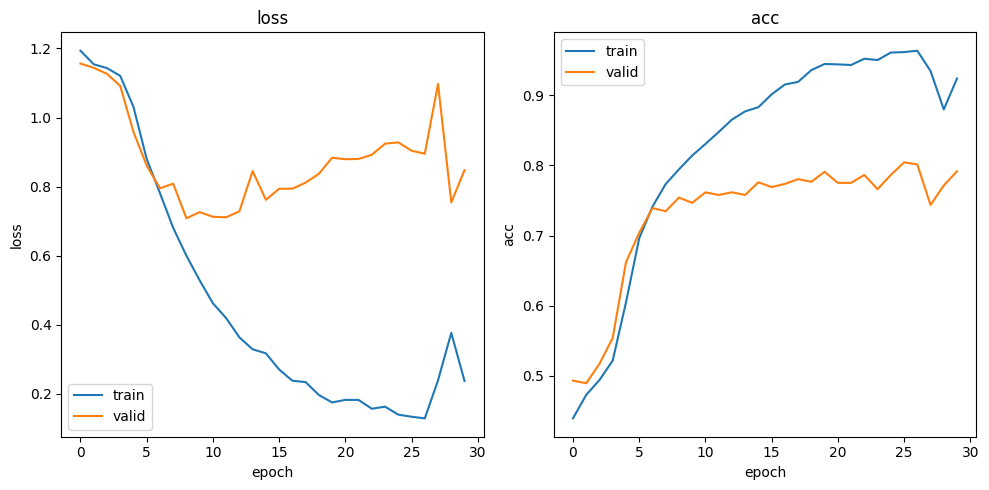

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig83.png')
plt.show()

In [ ]:
def calc_acc(net, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data).cpu()
    return corrects / len(dataloader.dataset)

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

学習データの正解率: 0.9412
検証データの正解率: 0.7916
テストデータの正解率: 0.7984


**84. 単語ベクトルの導入**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
file = 'drive/MyDrive/content/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(file, binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.1, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9042 / 9725
torch.Size([9725, 300])


Epoch 1 / 30 (train) Loss: 1.1965, Acc: 0.4156, (val) Loss: 1.1617, Acc: 0.4258
Epoch 2 / 30 (train) Loss: 1.1610, Acc: 0.4360, (val) Loss: 1.1610, Acc: 0.4280
Epoch 3 / 30 (train) Loss: 1.1597, Acc: 0.4497, (val) Loss: 1.1592, Acc: 0.4468
Epoch 4 / 30 (train) Loss: 1.1583, Acc: 0.4548, (val) Loss: 1.1573, Acc: 0.4648
Epoch 5 / 30 (train) Loss: 1.1560, Acc: 0.4684, (val) Loss: 1.1546, Acc: 0.4843
Epoch 6 / 30 (train) Loss: 1.1522, Acc: 0.4771, (val) Loss: 1.1501, Acc: 0.4693
Epoch 7 / 30 (train) Loss: 1.1477, Acc: 0.4867, (val) Loss: 1.1427, Acc: 0.4895
Epoch 8 / 30 (train) Loss: 1.1393, Acc: 0.5028, (val) Loss: 1.1305, Acc: 0.5142
Epoch 9 / 30 (train) Loss: 1.1210, Acc: 0.5221, (val) Loss: 1.0854, Acc: 0.5637
Epoch 10 / 30 (train) Loss: 1.0474, Acc: 0.5865, (val) Loss: 0.9883, Acc: 0.6349
Epoch 11 / 30 (train) Loss: 1.0140, Acc: 0.6109, (val) Loss: 1.0037, Acc: 0.6342
Epoch 12 / 30 (train) Loss: 0.9499, Acc: 0.6550, (val) Loss: 0.9126, Acc: 0.6822
Epoch 13 / 30 (train) Loss: 0.9272, A

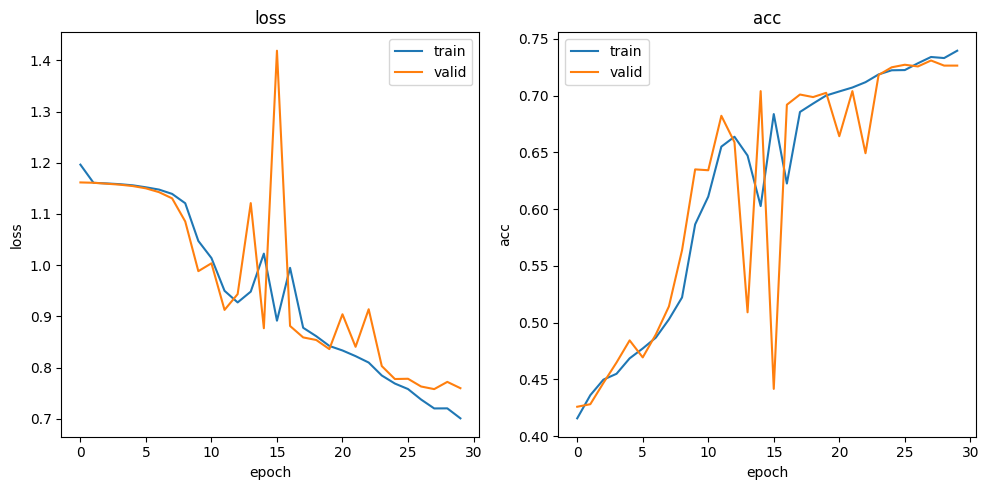

学習データの正解率: 0.7446
検証データの正解率: 0.7264
テストデータの正解率: 0.7294


In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers=1, emb_weights=None):
        super().__init__()
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(emb_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        x = self.emb(x)
        x, h = self.rnn(x, h0)
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2  # 辞書のID数 + unknown + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS, weights)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

num_epochs = 30
train_loss_weights, train_acc_weights, valid_loss_weights, valid_acc_weights = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss_weights, label='train')
ax[0].plot(epochs, valid_loss_weights, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc_weights, label='train')
ax[1].plot(epochs, valid_acc_weights, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig84.png')
plt.show()

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

**85. 双方向RNN・多層化**

Epoch 1 / 30 (train) Loss: 1.1727, Acc: 0.4152, (val) Loss: 1.1645, Acc: 0.4213
Epoch 2 / 30 (train) Loss: 1.1644, Acc: 0.4144, (val) Loss: 1.1644, Acc: 0.4213
Epoch 3 / 30 (train) Loss: 1.1585, Acc: 0.4373, (val) Loss: 1.1125, Acc: 0.5322
Epoch 4 / 30 (train) Loss: 1.1045, Acc: 0.5450, (val) Loss: 1.0495, Acc: 0.6462
Epoch 5 / 30 (train) Loss: 1.0159, Acc: 0.6265, (val) Loss: 0.9327, Acc: 0.6649
Epoch 6 / 30 (train) Loss: 0.9582, Acc: 0.6471, (val) Loss: 0.8688, Acc: 0.7001
Epoch 7 / 30 (train) Loss: 0.8862, Acc: 0.6836, (val) Loss: 1.0388, Acc: 0.5907
Epoch 8 / 30 (train) Loss: 0.9062, Acc: 0.6727, (val) Loss: 0.8806, Acc: 0.6874
Epoch 9 / 30 (train) Loss: 0.8105, Acc: 0.7109, (val) Loss: 0.7911, Acc: 0.7234
Epoch 10 / 30 (train) Loss: 0.9004, Acc: 0.6758, (val) Loss: 0.8276, Acc: 0.7069
Epoch 11 / 30 (train) Loss: 0.8962, Acc: 0.6508, (val) Loss: 1.1636, Acc: 0.3958
Epoch 12 / 30 (train) Loss: 1.1657, Acc: 0.4102, (val) Loss: 1.1659, Acc: 0.3958
Epoch 13 / 30 (train) Loss: 1.1655, A

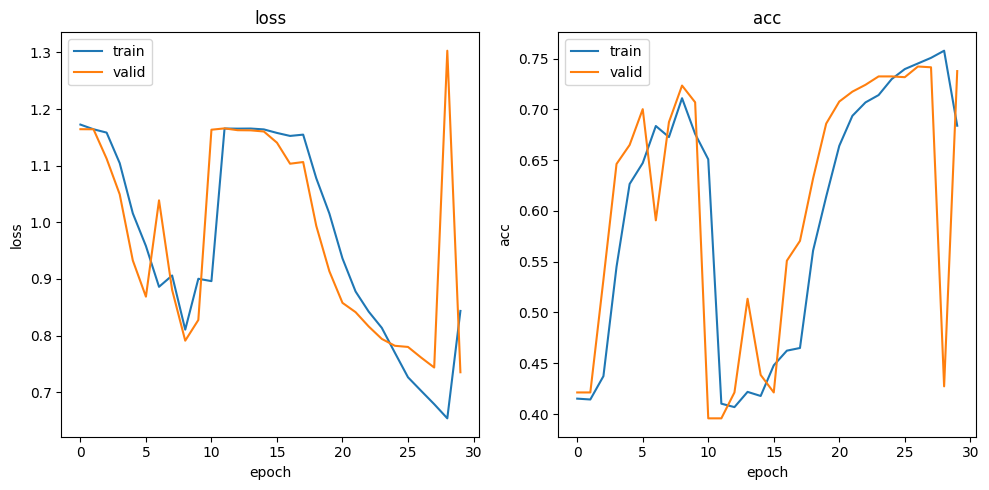

学習データの正解率: 0.7549
検証データの正解率: 0.7376
テストデータの正解率: 0.7316


In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, hidden_size, output_size, num_layers=3, emb_weights=None):
        super().__init__()
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x, h0=None):
        x = self.emb(x)
        x, h = self.rnn(x, h0)
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2  # 辞書のID数 + unknown + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 3

# モデルの定義
net = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS, weights)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

num_epochs = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig85.png')
plt.show()

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

**86. 畳み込みニューラルネットワーク (CNN)**

In [ ]:
from torch.nn import functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.4)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        logits = self.fc(self.drop(max_pool.squeeze(2)))
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
x = torch.tensor([tokenizer(sample)], dtype=torch.int64)
print(x)
print(x.size())
print(nn.Softmax(dim=-1)(model(x)))

tensor([[  68,   76,  782, 1974,   21, 5054, 5055,   34, 1602,    0]])
torch.Size([1, 10])
tensor([[0.2564, 0.2540, 0.2828, 0.2068]], grad_fn=<SoftmaxBackward0>)


**87. 確率的勾配降下法によるCNNの学習**

Epoch 1 / 30 (train) Loss: 0.9630, Acc: 0.6167, (val) Loss: 0.7365, Acc: 0.7421
Epoch 2 / 30 (train) Loss: 0.6770, Acc: 0.7527, (val) Loss: 0.6049, Acc: 0.7849
Epoch 3 / 30 (train) Loss: 0.5127, Acc: 0.8140, (val) Loss: 0.6062, Acc: 0.7909
Epoch 4 / 30 (train) Loss: 0.4027, Acc: 0.8578, (val) Loss: 0.5359, Acc: 0.8208
Epoch 5 / 30 (train) Loss: 0.3282, Acc: 0.8798, (val) Loss: 0.5185, Acc: 0.8201
Epoch 6 / 30 (train) Loss: 0.2660, Acc: 0.9083, (val) Loss: 0.5362, Acc: 0.8201
Epoch 7 / 30 (train) Loss: 0.2260, Acc: 0.9209, (val) Loss: 0.5216, Acc: 0.8351
Epoch 8 / 30 (train) Loss: 0.1916, Acc: 0.9355, (val) Loss: 0.5341, Acc: 0.8358
Epoch 9 / 30 (train) Loss: 0.1693, Acc: 0.9411, (val) Loss: 0.5303, Acc: 0.8486
Epoch 10 / 30 (train) Loss: 0.1513, Acc: 0.9461, (val) Loss: 0.5718, Acc: 0.8328
Epoch 11 / 30 (train) Loss: 0.1286, Acc: 0.9561, (val) Loss: 0.5823, Acc: 0.8396
Epoch 12 / 30 (train) Loss: 0.1194, Acc: 0.9579, (val) Loss: 0.5703, Acc: 0.8463
Epoch 13 / 30 (train) Loss: 0.1084, A

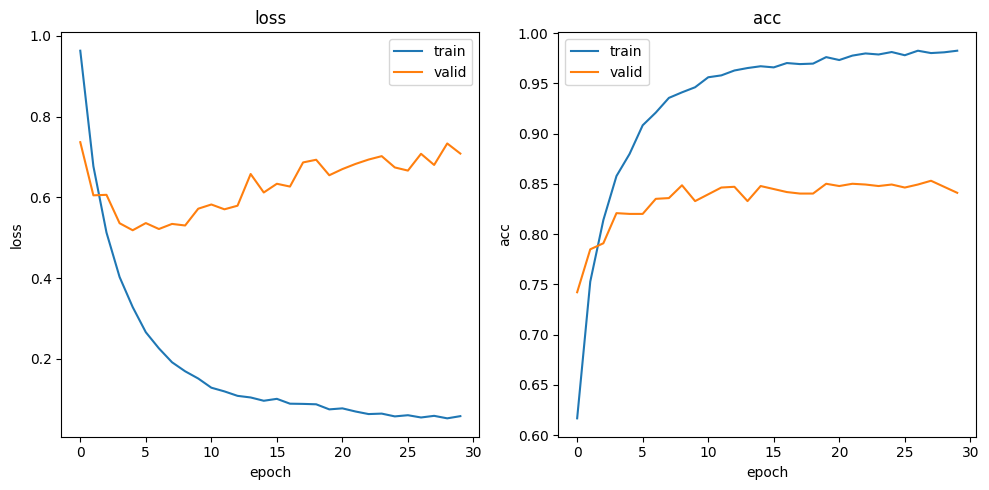

学習データの正解率: 0.9987
検証データの正解率: 0.8411
テストデータの正解率: 0.8561


In [ ]:
# モデルの定義
net = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

num_epochs = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig87.png')
plt.show()

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

**88. パラメータチューニング**

Epoch 1 / 30 (train) Loss: 1.0508, Acc: 0.5830, (val) Loss: 0.9038, Acc: 0.6544
Epoch 2 / 30 (train) Loss: 0.7912, Acc: 0.7212, (val) Loss: 0.7117, Acc: 0.7564
Epoch 3 / 30 (train) Loss: 0.6095, Acc: 0.7924, (val) Loss: 0.6105, Acc: 0.7894
Epoch 4 / 30 (train) Loss: 0.4827, Acc: 0.8370, (val) Loss: 0.5515, Acc: 0.8111
Epoch 5 / 30 (train) Loss: 0.3903, Acc: 0.8755, (val) Loss: 0.5132, Acc: 0.8193
Epoch 6 / 30 (train) Loss: 0.3156, Acc: 0.9031, (val) Loss: 0.4893, Acc: 0.8283
Epoch 7 / 30 (train) Loss: 0.2584, Acc: 0.9278, (val) Loss: 0.4714, Acc: 0.8478
Epoch 8 / 30 (train) Loss: 0.2118, Acc: 0.9473, (val) Loss: 0.4557, Acc: 0.8426
Epoch 9 / 30 (train) Loss: 0.1779, Acc: 0.9566, (val) Loss: 0.4452, Acc: 0.8456
Epoch 10 / 30 (train) Loss: 0.1496, Acc: 0.9680, (val) Loss: 0.4430, Acc: 0.8426
Epoch 11 / 30 (train) Loss: 0.1218, Acc: 0.9765, (val) Loss: 0.4461, Acc: 0.8463
Epoch 12 / 30 (train) Loss: 0.0982, Acc: 0.9834, (val) Loss: 0.4431, Acc: 0.8516
Epoch 13 / 30 (train) Loss: 0.0866, A

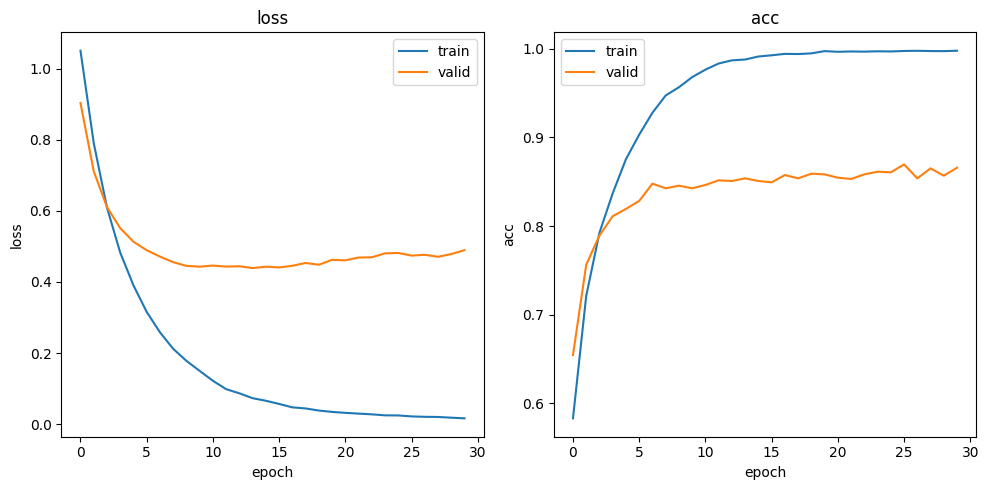

学習データの正解率: 0.9993
検証データの正解率: 0.8658
テストデータの正解率: 0.8801


In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.4)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        logits = self.fc(self.drop(max_pool.squeeze(2)))
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
OUT_CHANNELS = 500
KERNEL_HEIGHTS = 2
STRIDE = 1
PADDING = 1

# モデルの定義
net = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

num_epochs = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig88.png')
plt.show()

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

**89. 事前学習済み言語モデルからの転移学習**

準備

In [ ]:
# データのロード
import pandas as pd
import re
import numpy as np
import random
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
from torch import nn
from matplotlib import pyplot as plt

# 乱数のシードを設定
# parserなどで指定
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

# ファイル読み込み
file = './newsCorpora.csv'
data = pd.read_csv(file, encoding='utf-8', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
data = data.replace('"', "'")
# 特定のpublisherのみ抽出
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)

# 前処理
def preprocessing(text):
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    text_clean = re.sub('[0-9]+', '0', text_clean)
    text_clean = re.sub('\s-\s', ' ', text_clean)
    return text_clean

data['TITLE'] = data['TITLE'].apply(preprocessing)

# 学習用、検証用、評価用に分割する
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=64, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=64, stratify=valid_test['CATEGORY'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

# ターゲットのテンソル化
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['CATEGORY'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['CATEGORY'].map(category_dict).values)
Y_test = torch.from_numpy(test['CATEGORY'].map(category_dict).values)

学習データ
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64
検証データ
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64
評価データ
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
class BERTDataSet(Dataset):

    def __init__(self, X, y, phase):
        self.X = X['TITLE']
        self.y = y
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.phase = phase

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        sentence = self.X[idx]
        sentence = str(sentence)
        sentence = " ".join(sentence.split())

        bert_sens = self.tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True, # [CLS],[SEP]
                                max_length = 20,
                                pad_to_max_length = True, # add padding to blank
                                truncation=True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        labels = self.y[idx]

        return {
                'ids': ids,
                'mask': mask,
                'labels': labels,
                }

train_dataset = BERTDataSet(train, Y_train, phase='train')
valid_dataset = BERTDataSet(valid, Y_valid, phase='val')
test_dataset = BERTDataSet(test, Y_test, phase='val')

# 動作確認
train_dataset[0]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'ids': tensor([  101,  6796, 12170, 22669,  2104,  4812,  2005,  4692, 13742,  2012,
          4913, 18396,  2015,   102,     0,     0,     0,     0,     0,     0]),
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(2)}

In [ ]:
# DataLoaderを作成
batch_size = 64

train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
valid_dataloader = DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs = next(batch_iter)
print(inputs['ids'].size())
print(inputs['mask'].size())
print(inputs['labels'].size())

torch.Size([64, 20])
torch.Size([64, 20])
torch.Size([64])


構築・学習

In [ ]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, hidden_size, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(drop_rate)
        self.fc = nn.Sequential(
                                nn.Linear(768, hidden_size),
                                nn.ReLU(),
                                nn.BatchNorm1d(hidden_size),
                                nn.Linear(hidden_size, output_size)
                                )
        # self.fc = nn.Linear(768, output_size)  # BERTの出力に合わせて768次元を指定

    def forward(self, ids, mask):
        out = self.bert(ids, attention_mask=mask)[-1]
        out = self.fc(self.drop(out))
        return out

In [ ]:
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # ネットワークをgpuへ
    net.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for data in dataloaders_dict[phase]:
                # GPUが使えるならGPUにおくる
                ids = data['ids'].to(device)
                mask = data['mask'].to(device)
                labels = data['labels'].to(device)
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(ids, mask)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * ids.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())

        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
    return train_loss, train_acc, valid_loss, valid_acc


# パラメータの設定
DROP_RATE = 0.2
HIDDEN_SIZE = 256
OUTPUT_SIZE = 4
BATCH_SIZE = 64
NUM_EPOCHS = 8
LEARNING_RATE = 1e-5

# モデルの定義
net = BERTClass(DROP_RATE, HIDDEN_SIZE, OUTPUT_SIZE)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=net.parameters(), lr=LEARNING_RATE)

train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 1 / 8 (train) Loss: 0.6617, Acc: 0.7655, (val) Loss: 0.2767, Acc: 0.9108
Epoch 2 / 8 (train) Loss: 0.2771, Acc: 0.9193, (val) Loss: 0.2124, Acc: 0.9340
